# Feature Engineering

In [149]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
pd.set_option('display.max_columns', 1000) # shows all the columns
pd.set_option('display.float_format', lambda x: '%.4f' % x) # displays outputs with 1 decimal
pd.set_option('display.max_rows', 10000) # shows all the rows
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import matplotlib.ticker as mtick
from mizani.formatters import percent_format

Based on visualization, here I have created 3 features based on the information we have got from visualization

- Grouping Tenure in bins : Can give a visualization on how churning rate looks like over these groups
- Tenure group with only 12 months of tenure and rest to other group : creating another feature out of grouping tenure
- Customers availing multiple online Services- creating a feature tagging how many services does a customer avails
- Highest churning rate among customers using which services

###  Churn % with Tenure groups

We also see, that the churn Rate is highest, almost 50% for the customers with less than a year of tenure.

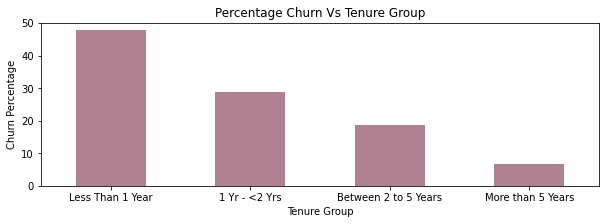

In [150]:
# Split the customers into 4 groups of tenures and see their Churn Rate
plt.figure(figsize=(10,3))
data['Tenure Group'] = 'Between 2 to 5 Years'
data.loc[data['Tenure Months'] >59,'Tenure Group'] = 'More than 5 Years' 
data.loc[(((data['Tenure Months'] > 12)) & (data['Tenure Months'] <= 24)),'Tenure Group'] = '1 Yr - <2 Yrs'
data.loc[data['Tenure Months'] <= 12,'Tenure Group'] = 'Less Than 1 Year'

data_rate = data.groupby('Tenure Group')['Churn Value'].mean().sort_values(ascending=False)
(round(100*data_rate,2)).plot.bar(color='#b08291')
plt.tick_params(rotation=0)

plt.ylabel('Churn Percentage')
plt.title('Percentage Churn Vs Tenure Group');

We can clearly see, that there is signficantly higher churning rate for customers having tenure less than 12 months

### Customers availing multiple online Services

There's 6 additional services for clients. Creating a feature which shows how many online services a customer has opted. And what is the churn % for that customer?

The figure shows that customers availing just one service has greater percentage of churning compared to customers availing all 6.

In [151]:
#count of online services availed
data['Count_OnlineServices'] = (data[['Online Security','Online Backup', 'Device Protection', 'Tech Support',
       'Streaming TV', 'Streaming Movies']] == 'Yes').sum(axis=1)
# data['Count_OnlineServices'] .value_counts()

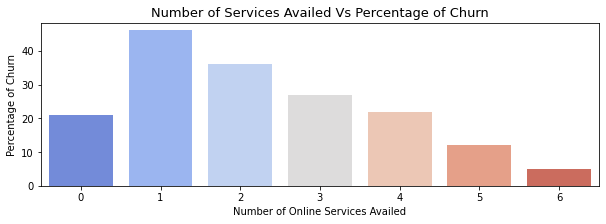

In [152]:
agg = data.replace('Yes',1).replace('No', 0).groupby('Count_OnlineServices', as_index=False)[['Churn Value']].mean()
agg[['Churn']] = np.round(agg[['Churn Value']], 2) * 100
plt.figure(figsize=(10,3))
ax = sns.barplot(x='Count_OnlineServices', y='Churn', data=agg,palette='coolwarm')
ax.set_xlabel('Number of Online Services Availed', fontsize=10)
ax.set_ylabel('Percentage of Churn', fontsize=10)
ax.set_title('Number of Services Availed Vs Percentage of Churn', fontsize=13);

### Highest Churning rate for which online service provided?

Almost 40 % of the clients avail Tv and movies streaming services : and the churning rate is the highest for this customers

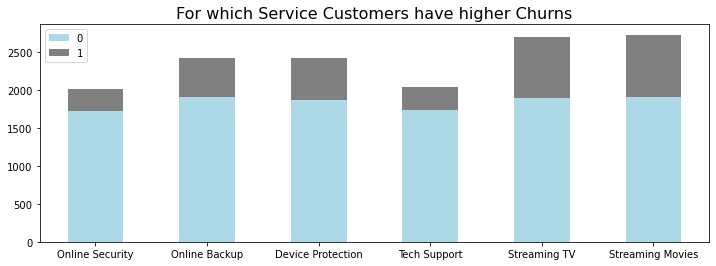

In [153]:
tempdf3 = data[['Online Security','Online Backup', 'Device Protection', 'Tech Support','Streaming TV', 
                'Streaming Movies', 'Churn Value']]
tempdf3.replace(to_replace='Yes', value=1, inplace=True)
tempdf3.replace(to_replace='No', value=0, inplace=True)
tempdf3.head()

tempdf4 = tempdf3[tempdf3['Online Security'] !='No internet service']             
agg = tempdf4.groupby('Churn Value', as_index=False)[['Online Security','Online Backup', 'Device Protection', 'Tech Support','Streaming TV', 
                'Streaming Movies']].sum()

ax = agg.set_index('Churn Value').T.plot(kind='bar', stacked=True, figsize=(12,4),color=['lightblue','grey'])
patches, labels = ax.get_legend_handles_labels()
ax.legend(patches, labels, loc='best')
ax.set_title('For which Service Customers have higher Churns', fontsize=16);
plt.tick_params(rotation=0);

Based on above information, creating a new features : 
* tagging customers who has opted streaming Tv and Movies
* Tenure with just less than 12 months

In [154]:
# data2=data.copy()
data['Streaming Services']=np.where(((data['Streaming Movies']=='Yes') | (data['Streaming TV']=='Yes')),1,0)
data['Tenure_Year_First']=np.where((data['Tenure Months']<=12),1,0)

### K- means clustering

Performing K means cluster on two significant features to understand if there is any clusters for the churning customers. 

With respective to the data size, 3 clustersare initiated.

The gree cluster has the maximum count of customers and  The number is more than sum of other two clusters. This indicates that relatively new customers but those who have subscribed to more services ( having higer monthly charges) are the ones who are more likely to leave.

 ***# of customers in each cluster: 


2    949
1    482
0    438
Name: Cluster, dtype: int64

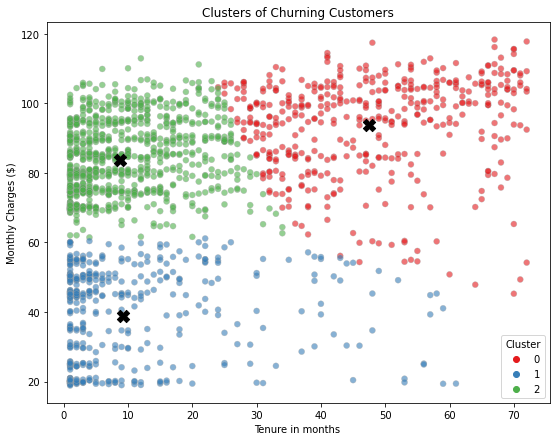

In [155]:
# Import KMeans Model
from sklearn.cluster import KMeans

# Graph and create 3 clusters of Customer Churn
tempdf=data[data['Churn Label']=='Yes'][["Tenure Months","Monthly Charges"]]
kmeans = KMeans(n_clusters=3, init='k-means++',random_state=2)
kmeans.fit(tempdf)
tempdf['Cluster']=kmeans.labels_

plt.figure(figsize=(9,7))
sns.scatterplot('Tenure Months', 'Monthly Charges', data = tempdf,  hue = 'Cluster',   palette = 'Set1', alpha = 0.6, 
               edgecolor = 'darkgrey')
plt.xlabel("Tenure in months ")
plt.ylabel("Monthly Charges ($)")
plt.scatter(x=kmeans.cluster_centers_[:,0],y=kmeans.cluster_centers_[:,1],color="black",marker="X",s=150)
plt.title("Clusters of Churning Customers");
print(" ***# of customers in each cluster: ")
tempdf['Cluster'].value_counts()
# plt.legend()

In [156]:
# dropping Churn Label which will not be used any more
drop=['Churn Label']
data.drop(drop,axis=1,inplace=True)

## Dummy creation for categorical variables which are not one-hot encoded

Creating dummies for all the categorical features . This is an important step so that each level of the categorical feature is given equal importance

In [157]:
dummy_vars=['Gender','Senior Citizen', 'Partner', 'Dependents','Phone Service','Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV','Streaming Movies', 'Contract', 
            'Paperless Billing', 'Payment Method','Tenure Group']
dummy_data=pd.get_dummies(data=data,columns=dummy_vars,drop_first=True)
dummy_data.head()

,Tenure Months,Monthly Charges,Total Charges,Churn Value,Count_OnlineServices,Streaming Services,Tenure_Year_First,Gender_Male,Senior Citizen_Yes,Partner_Yes,Dependents_Yes,Phone Service_Yes,Multiple Lines_No phone service,Multiple Lines_Yes,Internet Service_Fiber optic,Internet Service_No,Online Security_No internet service,Online Security_Yes,Online Backup_No internet service,Online Backup_Yes,Device Protection_No internet service,Device Protection_Yes,Tech Support_No internet service,Tech Support_Yes,Streaming TV_No internet service,Streaming TV_Yes,Streaming Movies_No internet service,Streaming Movies_Yes,Contract_One year,Contract_Two year,Paperless Billing_Yes,Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check,Tenure Group_Between 2 to 5 Years,Tenure Group_Less Than 1 Year,Tenure Group_More than 5 Years
0,2.0000,53.8500,108.1500,1,2,0,1,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0
1,2.0000,70.7000,151.6500,1,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0
2,8.0000,99.6500,820.5000,1,3,1,1,0,0,0,1,1,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,1,0,0,1,0
3,28.0000,104.8000,3046.0500,1,4,1,0,0,0,1,1,1,0,1,1,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,1,0,1,0,1,0,0
4,49.0000,103.7000,5036.3000,1,4,1,0,1,0,0,1,1,0,1,1,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0


## Correlation of Churn with other features

Creating a correlation chart to finally see which variables are correlated to with churning

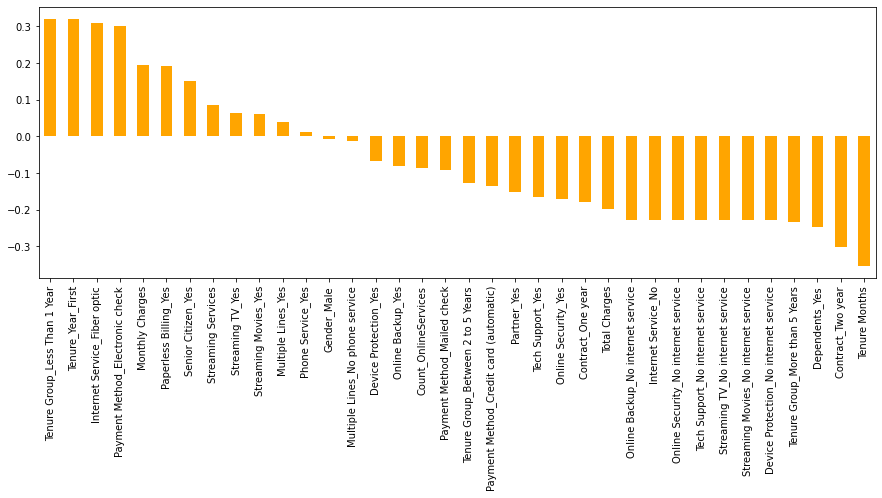

In [158]:
plt.figure(figsize=(15,5))
dummy_data.corr()['Churn Value'].sort_values(ascending = False).drop('Churn Value').plot(kind='bar',color=['orange']);